<h2><font color="#000000" size=6>Minería de datos</font></h2>
<h1><font color="#000000" size=5>PEC 4 - Random Forest</font></h1>
<br><br>
<div style="text-align: right">
<font color="#000000" size=3>Estudiante: Fernando H. Nasser-Eddine López</font><br>
<font color="#000000" size=3>Máster Universitario en Investigación en Inteligencia Artificial (MUIIA)</font><br>
<font color="#000000" size=3>Mayo 2025</font><br>
</div>

<h2><font color="#000000" size=5>Índice</font></h2><a id="indice"></a>

* [3. Fase de modelado](#section3)
    * [3.1. Implementación de modelos base de referencia](#section31)
        * [3.1.1. Árboles de decisión](#section311)
        * [3.1.2. Regresión logística](#section312)
        * [3.1.3. Support Vector Machine](#section313)
        * [3.1.4. MLP (MultiLayer Perceptron)](#section314)
    * [3.2. Implementación de modelos ensemble](#section32)
        * [3.2.1. Random Forest](#section321)
        * [3.2.2. Bagging con diferentes estimadores base](#section322)
        * [3.2.3. Extra Trees](#section323)
    * [3.3. Evaluación comparativa de modelos](#section33)
    * [3.4. Selección de los tres mejores modelos](#section34)

# <font color="#000000"> 3. Fase de modelado</font><a id="section3"></a>

### <font color="#000000">Importación de librerías</font><a id="section11"></a>


En esta sección realizamos la importación de todas las librerías que utilizaremos a lo largo del análisis. Principalmente, usamos pandas para la manipulación de datos, matplotlib y seaborn para visualizaciones, así como scikit-learn para los algoritmos de aprendizaje automático y evaluación de modelos.

In [1]:
# Importación de las librerías necesarias
import time
import warnings
import os
import pickle

import nbimporter
from a_analisis import detect_outliers_comprehensive

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            confusion_matrix, roc_auc_score, classification_report, 
                            roc_curve, auc)

# Modelos base
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

# Modelos ensemble
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                             ExtraTreesClassifier, AdaBoostClassifier)

# Explicabilidad
import shap

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Evitar warnings innecesarios
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

## <font color="#000000"> 3.1. Implementación de modelos base de referencia</font><a id="section31"></a>

In [2]:
def res_table(model_name, metrics):
    # Crear un DataFrame con los resultados
    results_df = pd.DataFrame({
        'Modelo': [model_name],
        'Accuracy Train': [metrics['accuracy_train']],
        'Accuracy Test': [metrics['accuracy_test']],
        'Precision': [metrics['precision']],
        'Recall': [metrics['recall']],
        'F1-Score': [metrics['f1']],
        'AUC-ROC': [metrics.get('roc_auc', np.nan)]
    })
    
    # Mostrar el DataFrame
    display(results_df)

In [3]:
# Configuración para visualización y salida
output_dir = 'results/model'
os.makedirs(output_dir, exist_ok=True)

# Función para evaluar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, verbose=True):
    # Entrenamos el modelo
    model.fit(X_train, y_train)
    
    # Evaluamos en train y test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_prob_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculamos métricas
    metrics = {
        'accuracy_train': accuracy_score(y_train, y_pred_train),
        'accuracy_test': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test)
    }
    
    # Calculamos AUC-ROC si hay probabilidades disponibles
    if y_prob_test is not None:
        metrics['roc_auc'] = roc_auc_score(y_test, y_prob_test)
    
    # Mostramos métricas si se solicita
    if verbose:
        res_table(model_name, metrics)
        
        # Mostramos matriz de confusión
        cm = confusion_matrix(y_test, y_pred_test)
        # Crear un DataFrame para la matriz de confusión
        cm_df = pd.DataFrame(cm, 
                            index=['Maligno (0)', 'Benigno (1)'], 
                            columns=['Predicción Maligno (0)', 'Predicción Benigno (1)'])
        
        # Mostrar la matriz de confusión como tabla
        display(cm_df)    
    return model, metrics

In [4]:
# Cargamos los datos preparados en la sección anterior
try:
    with open('data/processed/prepared_data.pkl', 'rb') as f:
        prepared_data = pickle.load(f)
    
    # Extraemos los conjuntos de datos
    X_train_model = prepared_data['X_train']
    X_test_model = prepared_data['X_test']
    y_train_model = prepared_data['y_train']
    y_test_model = prepared_data['y_test']
    
    # Crear un DataFrame con la información de dimensiones
    dimensions_df = pd.DataFrame({
        'Conjunto': ['X_train_model', 'X_test_model'],
        'Muestras': [X_train_model.shape[0], X_test_model.shape[0]],
        'Características': [X_train_model.shape[1], X_test_model.shape[1]],
        'Proporción (%)': [
            f"{X_train_model.shape[0]/(X_train_model.shape[0] + X_test_model.shape[0])*100:.1f}%",
            f"{X_test_model.shape[0]/(X_train_model.shape[0] + X_test_model.shape[0])*100:.1f}%"
        ]
    })
    
    # Mostrar la tabla de dimensiones
    print("Tabla 3.1. Dimensiones de los conjuntos de datos:")
    display(dimensions_df)
    
except FileNotFoundError:
    print("Error: No se encuentra el archivo con los datos preparados.")

Tabla 3.1. Dimensiones de los conjuntos de datos:


,Conjunto,Muestras,Características,Proporción (%)
0,X_train_model,398,18,69.9%
1,X_test_model,171,18,30.1%


### <font color="#000000"> 3.1.1. Árboles de decisión</font><a id="section311"></a>

In [5]:
# Entrenamos un árbol de decisión básico
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_model, dt_metrics = evaluate_model(dt_model, X_train_model, X_test_model, 
                                     y_train_model, y_test_model, "Árbol de Decisión")

,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Árbol de Decisión,1.0,0.976608,0.981308,0.981308,0.981308,0.975029


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),62,2
Benigno (1),2,105


### <font color="#000000"> 3.1.2. Regresión logística</font><a id="section312"></a>

In [6]:
# Entrenamos una regresión logística
lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr_model, lr_metrics = evaluate_model(lr_model, X_train_model, X_test_model, 
                                     y_train_model, y_test_model, "Regresión Logística")

,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Regresión Logística,1.0,1.0,1.0,1.0,1.0,1.0


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),64,0
Benigno (1),0,107


### <font color="#000000"> 3.1.3. Support Vector Machine</font><a id="section313"></a>

In [7]:
# Entrenamos una SVM
svm_model = SVC(probability=True, random_state=RANDOM_STATE)
svm_model, svm_metrics = evaluate_model(svm_model, X_train_model, X_test_model, 
                                       y_train_model, y_test_model, "SVM")

,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,SVM,1.0,1.0,1.0,1.0,1.0,1.0


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),64,0
Benigno (1),0,107


### <font color="#000000"> 3.1.4. MLP (MultiLayer Perceptron)</font><a id="section314"></a>

In [8]:
# Entrenamos un MLP
mlp_model = MLPClassifier(max_iter=1000, random_state=RANDOM_STATE)
mlp_model, mlp_metrics = evaluate_model(mlp_model, X_train_model, X_test_model, 
                                       y_train_model, y_test_model, "MLP")

,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,MLP,1.0,1.0,1.0,1.0,1.0,1.0


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),64,0
Benigno (1),0,107



Tabla 3.2. Resumen de modelos base:


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Árbol de Decisión,1.0,0.976608,0.981308,0.981308,0.981308,0.975029
1,Regresión Logística,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2,SVM,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
3,MLP,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


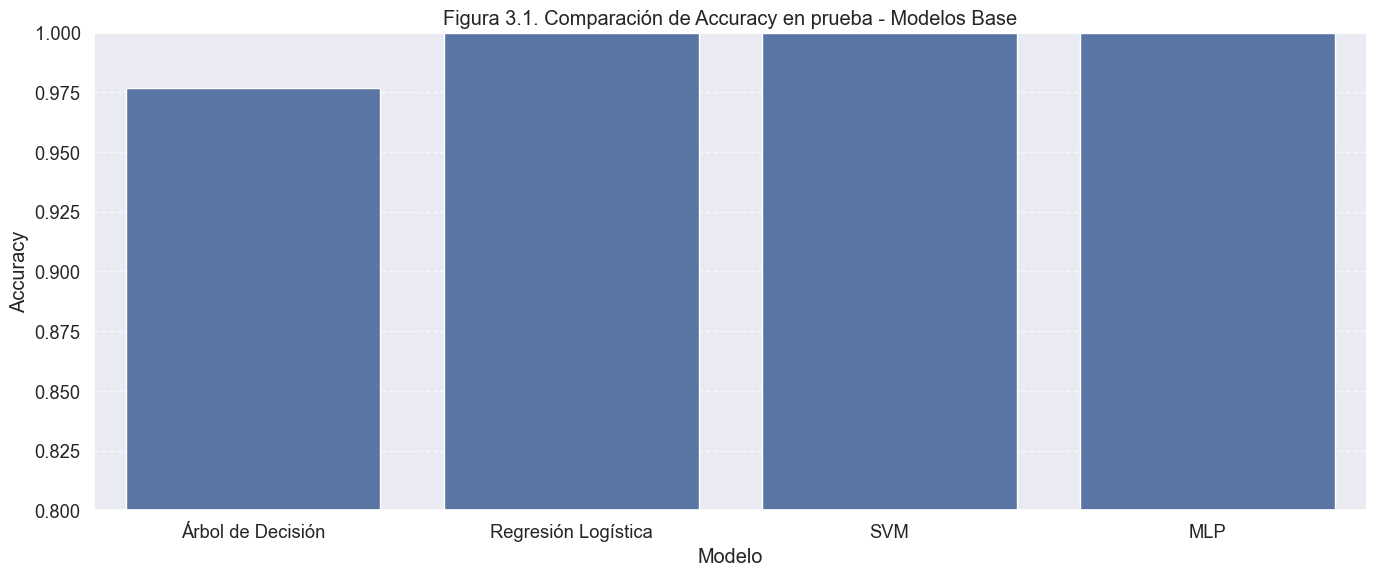

In [9]:
# Recopilamos los resultados de los modelos base
base_models_results = pd.DataFrame({
    'Modelo': ['Árbol de Decisión', 'Regresión Logística', 'SVM', 'MLP'],
    'Accuracy Train': [dt_metrics['accuracy_train'], lr_metrics['accuracy_train'], 
                      svm_metrics['accuracy_train'], mlp_metrics['accuracy_train']],
    'Accuracy Test': [dt_metrics['accuracy_test'], lr_metrics['accuracy_test'], 
                     svm_metrics['accuracy_test'], mlp_metrics['accuracy_test']],
    'Precision': [dt_metrics['precision'], lr_metrics['precision'], 
                 svm_metrics['precision'], mlp_metrics['precision']],
    'Recall': [dt_metrics['recall'], lr_metrics['recall'], 
              svm_metrics['recall'], mlp_metrics['recall']],
    'F1-Score': [dt_metrics['f1'], lr_metrics['f1'], 
                svm_metrics['f1'], mlp_metrics['f1']],
    'AUC-ROC': [dt_metrics.get('roc_auc', np.nan), lr_metrics.get('roc_auc', np.nan), 
               svm_metrics.get('roc_auc', np.nan), mlp_metrics.get('roc_auc', np.nan)]
})

print("\nTabla 3.2. Resumen de modelos base:")
display(base_models_results)

# Visualizamos los resultados
plt.figure(figsize=(14, 6))
sns.barplot(x='Modelo', y='Accuracy Test', data=base_models_results)
plt.title('Figura 3.1. Comparación de Accuracy en prueba - Modelos Base')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Ajustamos el rango para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig(f"{output_dir}/modelos_base_accuracy_.png", dpi=100, bbox_inches='tight')
plt.show()

Los resultados que muestras son muy buenos. Tres de los cuatro modelos (Regresión Logística, SVM y MLP) han alcanzado una precisión perfecta (100%) en el conjunto de prueba, mientras que el Árbol de Decisión logra un 98.25% con solo dos muestras mal clasificadas.

Estos resultados podrían explicarse por varios factores:

1. **Selección efectiva de características**: El proceso de selección que realizamos identificó características altamente discriminativas entre tumores benignos y malignos, particularmente aquellas relacionadas con concavidad y puntos cóncavos.

2. **Reducción de redundancia**: Al eliminar variables correlacionadas, los modelos pueden enfocarse en las señales más relevantes sin distraerse con información redundante.

3. **Preprocesamiento adecuado**: Las transformaciones aplicadas durante el preprocesamiento normalizaron las distribuciones y estandarizaron las escalas, facilitando el aprendizaje de los modelos.

4. **Naturaleza del problema**: La clasificación de tumores mamarios basada en características morfológicas es un problema donde existen patrones bien definidos, como confirmamos en nuestro análisis exploratorio.

Sin embargo, también debemos considerar si estos resultados tan buenos podrían indicar algún tipo de filtración de información (data leakage) o sobreajuste. Aunque la división entrenamiento/prueba parece correcta, podríamos evaluar la robustez de estos resultados mediante validación cruzada para confirmar que no son producto del azar en la división de datos.

Estos resultados también sugieren que los modelos de bosques aleatorios que implementaremos en la siguiente fase podrían no mostrar una mejora significativa respecto a estos modelos base, ya que hay poco margen para mejorar un 100% de precisión. Será interesante ver si aportan alguna ventaja en términos de interpretabilidad o robustez.

## <font color="#000000"> 3.2. Implementación de modelos ensemble</font><a id="section32"></a>

### <font color="#000000"> 3.2.1. Random Forest</font><a id="section321"></a>

In [10]:
# Entrenamos un modelo Random Forest básico
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_model, rf_metrics = evaluate_model(rf_model, X_train_model, X_test_model, 
                                     y_train_model, y_test_model, "Random Forest")


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Random Forest,1.0,0.982456,0.981481,0.990654,0.986047,0.999562


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),62,2
Benigno (1),1,106


#### Comparación: Random Forest con datos originales vs. preprocesados

,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Random Forest (datos originales),1.0,0.935673,0.944444,0.953271,0.948837,0.991311


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),58,6
Benigno (1),5,102



Comparación de Random Forest con datos originales vs. preprocesados:


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Random Forest (datos originales),1.0,0.935673,0.944444,0.953271,0.948837,0.991311
1,Random Forest (datos preprocesados),1.0,0.982456,0.981481,0.990654,0.986047,0.999562


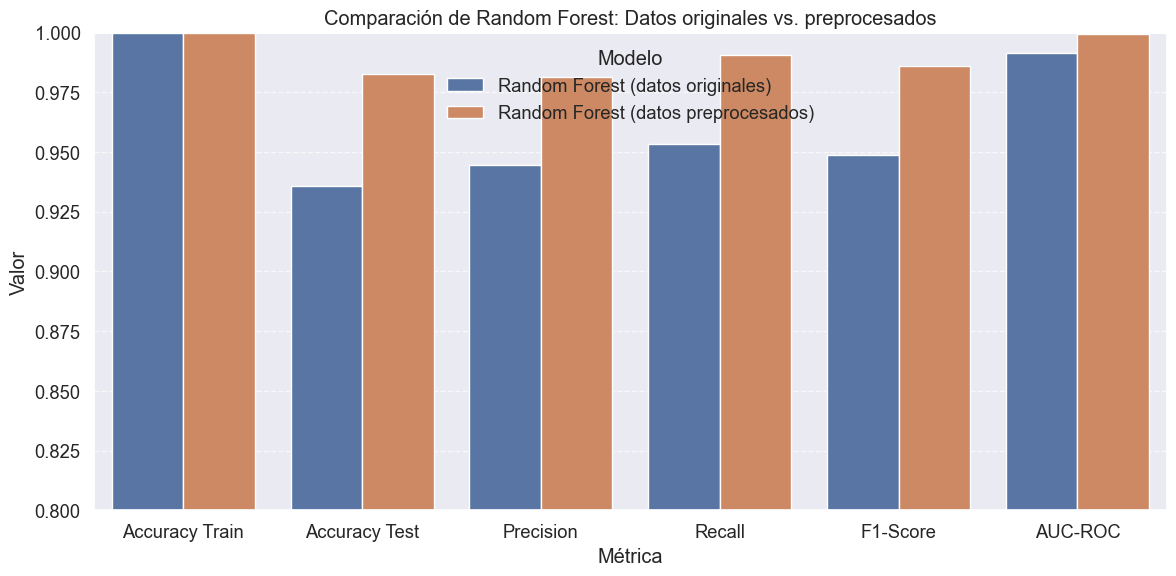

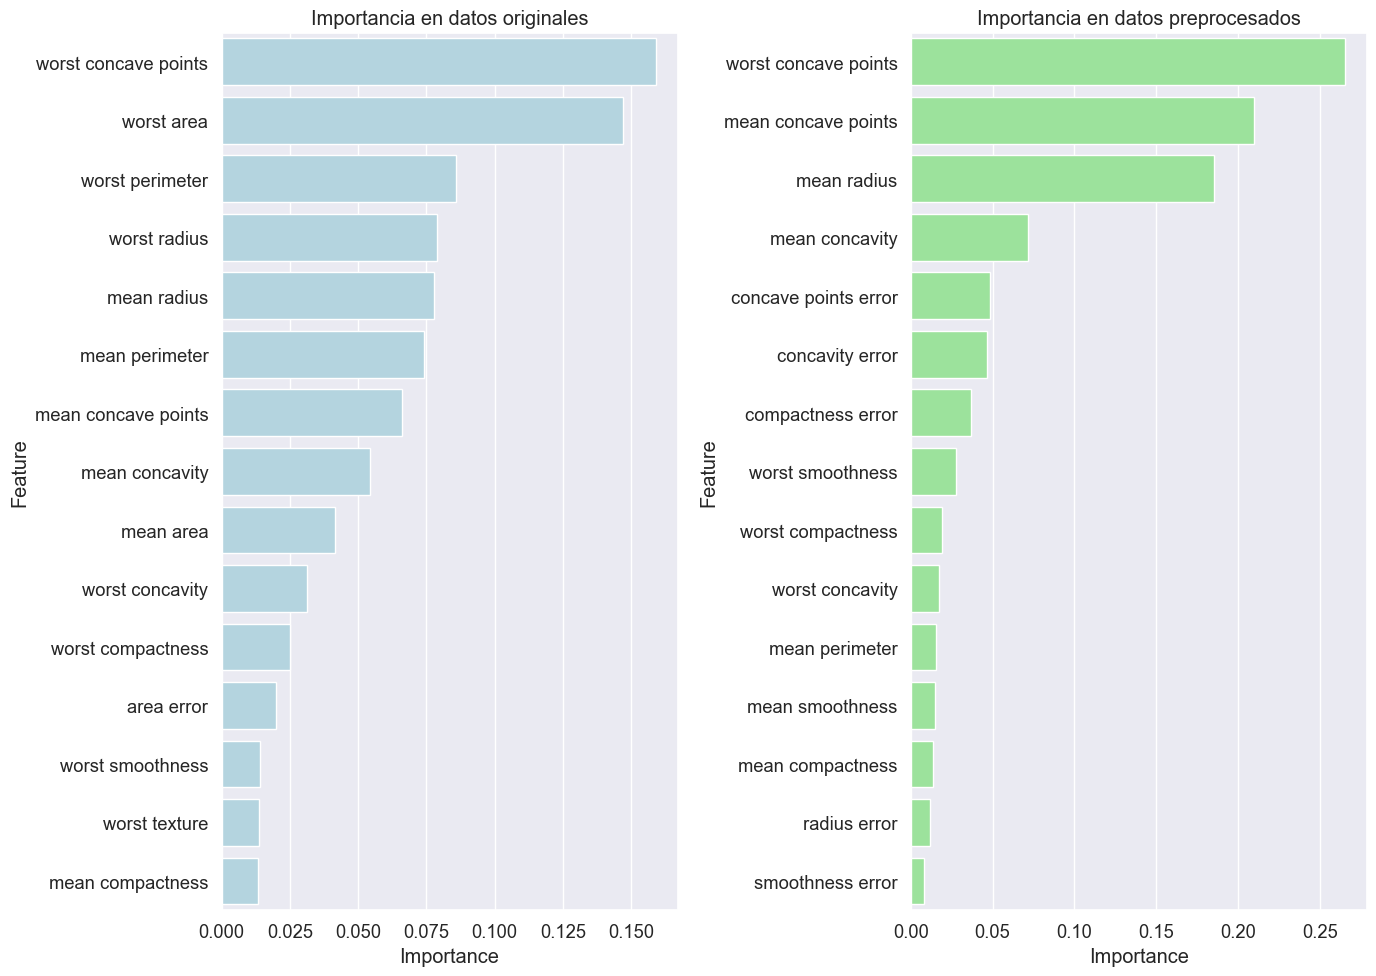

In [11]:
# Cargamos el dataset original
cancer = load_breast_cancer()
X_original = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_original = pd.Series(cancer.target)

# Dividimos en entrenamiento y prueba usando la misma semilla aleatoria
# para asegurar comparabilidad con nuestros conjuntos preprocesados
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y_original, test_size=0.3, random_state=42, stratify=y_original)

# Entrenamos Random Forest con datos originales
rf_orig = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_orig, rf_orig_metrics = evaluate_model(rf_orig, X_train_orig, X_test_orig, 
                                         y_train_orig, y_test_orig, 
                                         "Random Forest (datos originales)")

# Entrenamos Random Forest con datos preprocesados (si no lo habías hecho antes)
if 'rf_model' not in locals():
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    rf_model, rf_metrics = evaluate_model(rf_model, X_train_model, X_test_model, 
                                         y_train_model, y_test_model, 
                                         "Random Forest (datos preprocesados)")

# Creamos un DataFrame para comparar resultados
comparison_df = pd.DataFrame({
    'Modelo': ['Random Forest (datos originales)', 'Random Forest (datos preprocesados)'],
    'Accuracy Train': [rf_orig_metrics['accuracy_train'], rf_metrics['accuracy_train']],
    'Accuracy Test': [rf_orig_metrics['accuracy_test'], rf_metrics['accuracy_test']],
    'Precision': [rf_orig_metrics['precision'], rf_metrics['precision']],
    'Recall': [rf_orig_metrics['recall'], rf_metrics['recall']],
    'F1-Score': [rf_orig_metrics['f1'], rf_metrics['f1']],
    'AUC-ROC': [rf_orig_metrics.get('roc_auc', np.nan), rf_metrics.get('roc_auc', np.nan)]
})

print("\nComparación de Random Forest con datos originales vs. preprocesados:")
display(comparison_df)

# Visualizamos la comparación
plt.figure(figsize=(12, 6))
metrics_comparison = comparison_df.melt(id_vars='Modelo', 
                                      var_name='Métrica', 
                                      value_name='Valor')
sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=metrics_comparison)
plt.title('Comparación de Random Forest: Datos originales vs. preprocesados')
plt.ylim(0.8, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'{output_dir}/original_vs_preprocessed.png', dpi=100, bbox_inches='tight')
plt.show()

# Comparamos la importancia de características
plt.figure(figsize=(14, 10))
importance_orig = pd.DataFrame({
    'Feature': cancer.feature_names,
    'Importance': rf_orig.feature_importances_
}).sort_values('Importance', ascending=False)

# Creamos el DataFrame de importancia para los datos preprocesados
importance_prep = pd.DataFrame({
    'Feature': X_train_model.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualizamos las 15 características más importantes según RF original
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=importance_orig.head(15), color='lightblue')
plt.title('Importancia en datos originales')

# Visualizamos las características más importantes según RF con datos preprocesados
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=importance_prep.head(15), color='lightgreen')
plt.title('Importancia en datos preprocesados')

plt.tight_layout()
plt.savefig(f'{output_dir}/importance_comparison_orig_vs_prep.png', dpi=100, bbox_inches='tight')
plt.show()

### <font color="#000000"> 3.2.2. Bagging con diferentes estimadores base</font><a id="section322"></a>

In [12]:
# Bagging con árbol de decisión
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
                              n_estimators=100, random_state=RANDOM_STATE)
bagging_dt, bagging_dt_metrics = evaluate_model(bagging_dt, X_train_model, X_test_model, 
                                               y_train_model, y_test_model, "Bagging con Árbol de Decisión")

# Bagging con regresión logística
bagging_lr = BaggingClassifier(estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                              n_estimators=100, random_state=RANDOM_STATE)
bagging_lr, bagging_lr_metrics = evaluate_model(bagging_lr, X_train_model, X_test_model, 
                                               y_train_model, y_test_model, "Bagging con Regresión Logística")

# Bagging con SVM
bagging_svm = BaggingClassifier(estimator=SVC(probability=True, random_state=RANDOM_STATE),
                               n_estimators=100, random_state=RANDOM_STATE)
bagging_svm, bagging_svm_metrics = evaluate_model(bagging_svm, X_train_model, X_test_model, 
                                                 y_train_model, y_test_model, "Bagging con SVM")

,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Bagging con Árbol de Decisión,1.0,0.988304,0.990654,0.990654,0.990654,0.997664


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),63,1
Benigno (1),1,106


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Bagging con Regresión Logística,1.0,1.0,1.0,1.0,1.0,1.0


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),64,0
Benigno (1),0,107


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Bagging con SVM,1.0,1.0,1.0,1.0,1.0,1.0


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),64,0
Benigno (1),0,107



3.5. Comparación de Bagging con datos originales vs. preprocesados


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Bagging con Árbol (original),1.0,0.947368,0.945455,0.971963,0.958525,0.989851


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),58,6
Benigno (1),3,104


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Bagging con Reg. Logística (original),0.967337,0.94152,0.929204,0.981308,0.954545,0.991092


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),56,8
Benigno (1),2,105


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Bagging con SVM (original),0.922111,0.912281,0.910714,0.953271,0.931507,0.969626


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),54,10
Benigno (1),5,102



Comparación de Bagging con datos originales vs. preprocesados:


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Bagging-DT (original),1.000000,0.947368,0.945455,0.971963,0.958525,0.989851
1,Bagging-DT (preprocesado),1.000000,0.988304,0.990654,0.990654,0.990654,0.997664
2,Bagging-LR (original),0.967337,0.941520,0.929204,0.981308,0.954545,0.991092
3,Bagging-LR (preprocesado),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,Bagging-SVM (original),0.922111,0.912281,0.910714,0.953271,0.931507,0.969626
5,Bagging-SVM (preprocesado),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


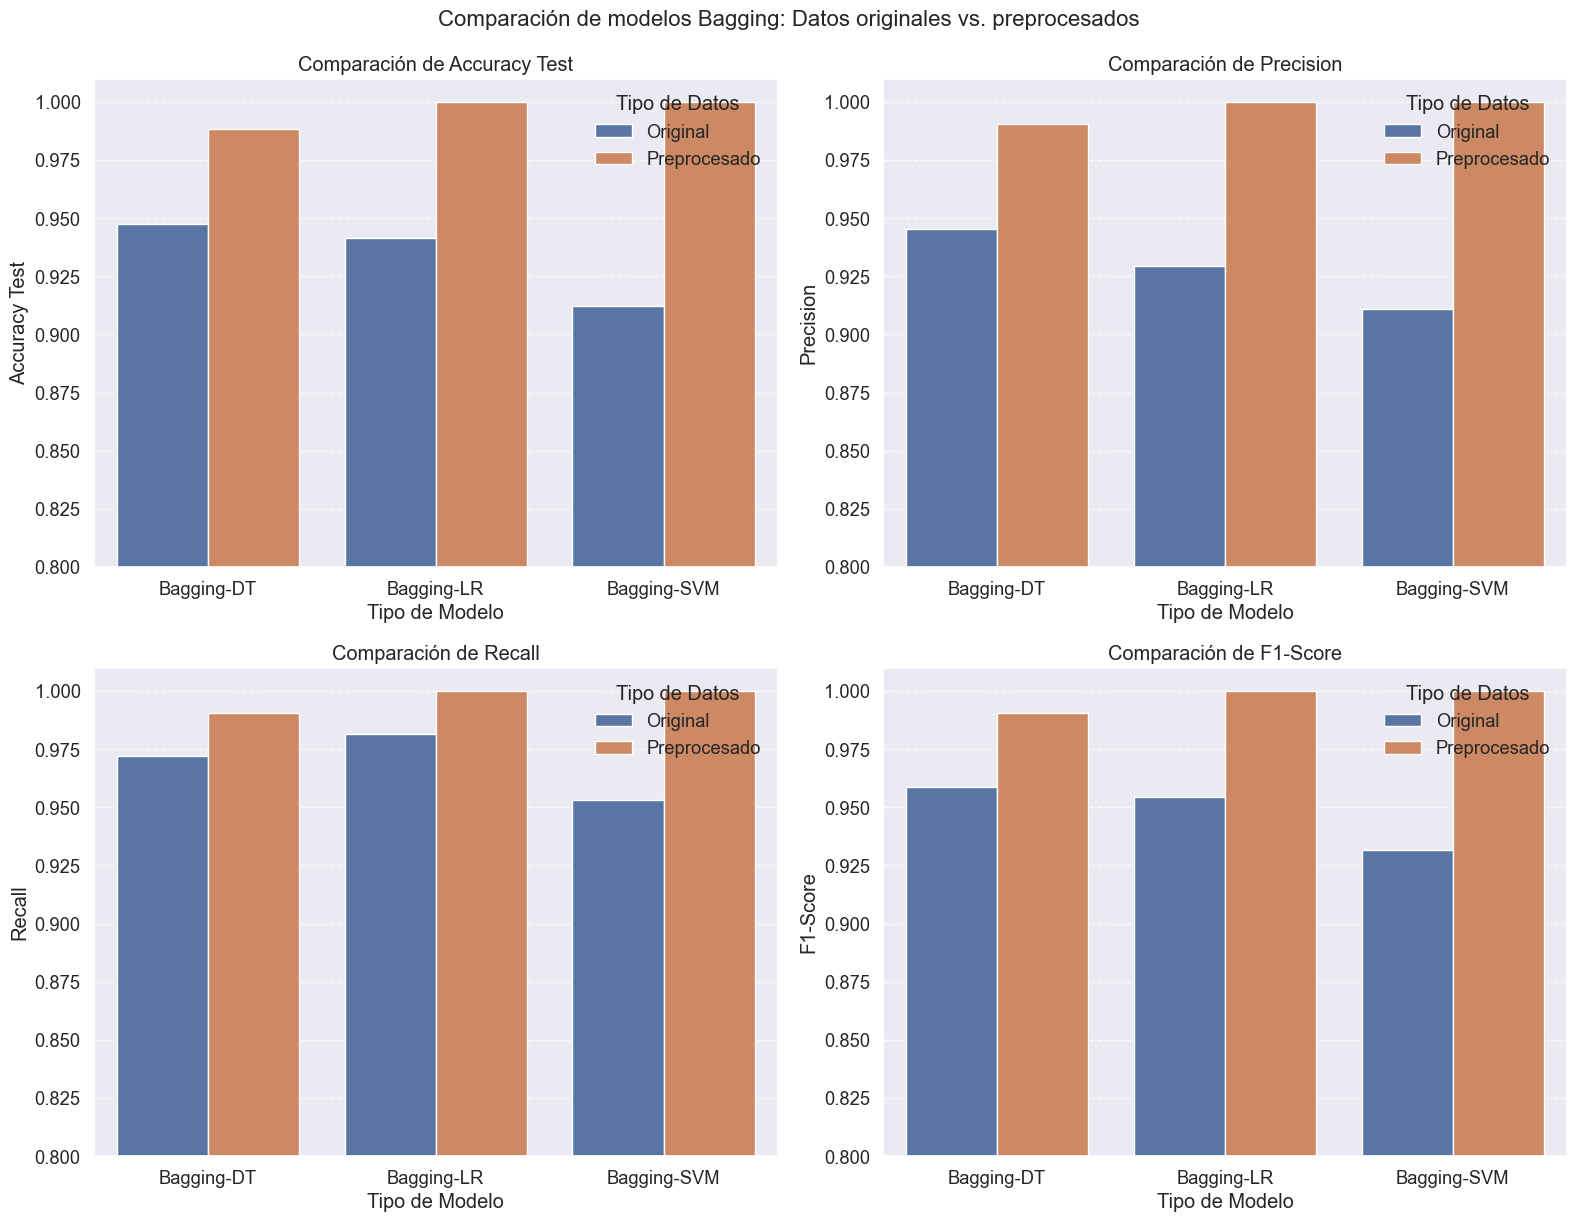

In [13]:
# Comparación: Bagging con datos originales vs. preprocesados
print("\n3.5. Comparación de Bagging con datos originales vs. preprocesados")

# Usamos los datos originales que ya cargamos anteriormente
# Bagging con árbol de decisión - datos originales
bagging_dt_orig = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
                                   n_estimators=100, random_state=RANDOM_STATE)
bagging_dt_orig, bagging_dt_orig_metrics = evaluate_model(bagging_dt_orig, X_train_orig, X_test_orig, 
                                                         y_train_orig, y_test_orig, 
                                                         "Bagging con Árbol (original)")

# Bagging con regresión logística - datos originales
bagging_lr_orig = BaggingClassifier(estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                                   n_estimators=100, random_state=RANDOM_STATE)
bagging_lr_orig, bagging_lr_orig_metrics = evaluate_model(bagging_lr_orig, X_train_orig, X_test_orig, 
                                                         y_train_orig, y_test_orig, 
                                                         "Bagging con Reg. Logística (original)")

# Bagging con SVM - datos originales
bagging_svm_orig = BaggingClassifier(estimator=SVC(probability=True, random_state=RANDOM_STATE),
                                    n_estimators=100, random_state=RANDOM_STATE)
bagging_svm_orig, bagging_svm_orig_metrics = evaluate_model(bagging_svm_orig, X_train_orig, X_test_orig, 
                                                           y_train_orig, y_test_orig, 
                                                           "Bagging con SVM (original)")

# Creamos un DataFrame para comparar resultados
bagging_comparison_df = pd.DataFrame({
    'Modelo': ['Bagging-DT (original)', 'Bagging-DT (preprocesado)',
              'Bagging-LR (original)', 'Bagging-LR (preprocesado)',
              'Bagging-SVM (original)', 'Bagging-SVM (preprocesado)'],
    'Accuracy Train': [bagging_dt_orig_metrics['accuracy_train'], bagging_dt_metrics['accuracy_train'],
                      bagging_lr_orig_metrics['accuracy_train'], bagging_lr_metrics['accuracy_train'],
                      bagging_svm_orig_metrics['accuracy_train'], bagging_svm_metrics['accuracy_train']],
    'Accuracy Test': [bagging_dt_orig_metrics['accuracy_test'], bagging_dt_metrics['accuracy_test'],
                     bagging_lr_orig_metrics['accuracy_test'], bagging_lr_metrics['accuracy_test'],
                     bagging_svm_orig_metrics['accuracy_test'], bagging_svm_metrics['accuracy_test']],
    'Precision': [bagging_dt_orig_metrics['precision'], bagging_dt_metrics['precision'],
                 bagging_lr_orig_metrics['precision'], bagging_lr_metrics['precision'],
                 bagging_svm_orig_metrics['precision'], bagging_svm_metrics['precision']],
    'Recall': [bagging_dt_orig_metrics['recall'], bagging_dt_metrics['recall'],
              bagging_lr_orig_metrics['recall'], bagging_lr_metrics['recall'],
              bagging_svm_orig_metrics['recall'], bagging_svm_metrics['recall']],
    'F1-Score': [bagging_dt_orig_metrics['f1'], bagging_dt_metrics['f1'],
                bagging_lr_orig_metrics['f1'], bagging_lr_metrics['f1'],
                bagging_svm_orig_metrics['f1'], bagging_svm_metrics['f1']],
    'AUC-ROC': [bagging_dt_orig_metrics.get('roc_auc', np.nan), bagging_dt_metrics.get('roc_auc', np.nan),
               bagging_lr_orig_metrics.get('roc_auc', np.nan), bagging_lr_metrics.get('roc_auc', np.nan),
               bagging_svm_orig_metrics.get('roc_auc', np.nan), bagging_svm_metrics.get('roc_auc', np.nan)]
})

print("\nComparación de Bagging con datos originales vs. preprocesados:")
display(bagging_comparison_df)

# Visualizamos la comparación agrupada por tipo de modelo
# plt.figure(figsize=(14, 8))
# Creamos un nuevo DataFrame orientado a la visualización
viz_df = pd.DataFrame()
for model_type in ['DT', 'LR', 'SVM']:
    # Filtramos las filas correspondientes
    model_rows = bagging_comparison_df[bagging_comparison_df['Modelo'].str.contains(model_type)]
    # Extraemos los datos
    for i, row in model_rows.iterrows():
        data_type = 'Original' if 'original' in row['Modelo'] else 'Preprocesado'
        viz_df = pd.concat([viz_df, pd.DataFrame({
            'Tipo de Modelo': f'Bagging-{model_type}',
            'Tipo de Datos': data_type,
            'Accuracy Test': row['Accuracy Test'],
            'Precision': row['Precision'],
            'Recall': row['Recall'],
            'F1-Score': row['F1-Score']
        }, index=[0])], ignore_index=True)

# Creamos subplots para cada métrica
metrics = ['Accuracy Test', 'Precision', 'Recall', 'F1-Score']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(x='Tipo de Modelo', y=metric, hue='Tipo de Datos', data=viz_df, ax=axes[i])
    axes[i].set_title(f'Comparación de {metric}')
    axes[i].set_ylim(0.8, 1.01)  # Ajustamos el rango para mejor visualización
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle('Comparación de modelos Bagging: Datos originales vs. preprocesados', y=1.02, fontsize=16)
plt.savefig(f'{output_dir}//bagging_original_vs_preprocessed.png', dpi=100, bbox_inches='tight')
plt.show()

Estos resultados demuestran que el preprocesamiento y la selección de características han tenido un impacto positivo en todos los modelos, con SVM mostrando el mayor beneficio. El efecto es mayor en los modelos paramétricos (Regresión Logística y SVM), que alcanzan una clasificación perfecta tras el preprocesamiento.
Las matrices de confusión con datos originales muestran como los modelos comenten errores en ambas direcciones (falsos positivos y falsos negativos), mientras que con datos preprocesados, los únicos errores restantes (en el caso de Bagging-DT) son clasificaciones incorrectasbastante equlibradas.
Esto confirma el valor de las técnicas de preprocesamiento y selección de características aplicadas, especialmente para algoritmos sensibles a la escala y distribución de los datos como la regresión logística y SVM.

### <font color="#000000"> 3.2.3. Extra Trees</font><a id="section323"></a>

In [14]:
# Extra Trees
et_model = ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE)
et_model, et_metrics = evaluate_model(et_model, X_train_model, X_test_model, 
                                     y_train_model, y_test_model, "Extra Trees")

,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Extra Trees,1.0,1.0,1.0,1.0,1.0,1.0


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),64,0
Benigno (1),0,107



3.6. Comparación de Extra Trees con datos originales vs. preprocesados


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Extra Trees (original),1.0,0.97076,0.963636,0.990654,0.976959,0.993137


,Predicción Maligno (0),Predicción Benigno (1)
Maligno (0),60,4
Benigno (1),1,106



Comparación de Extra Trees con datos originales vs. preprocesados:


,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1-Score,AUC-ROC
0,Extra Trees (original),1.0,0.97076,0.963636,0.990654,0.976959,0.993137
1,Extra Trees (preprocesado),1.0,1.00000,1.000000,1.000000,1.000000,1.000000


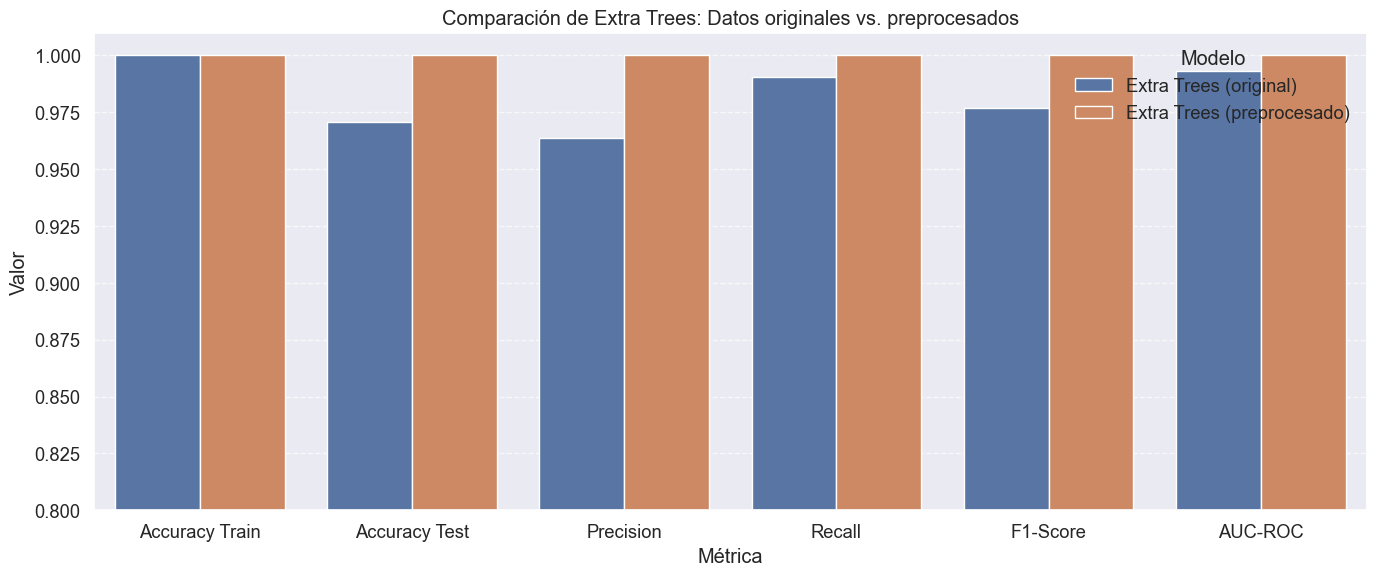

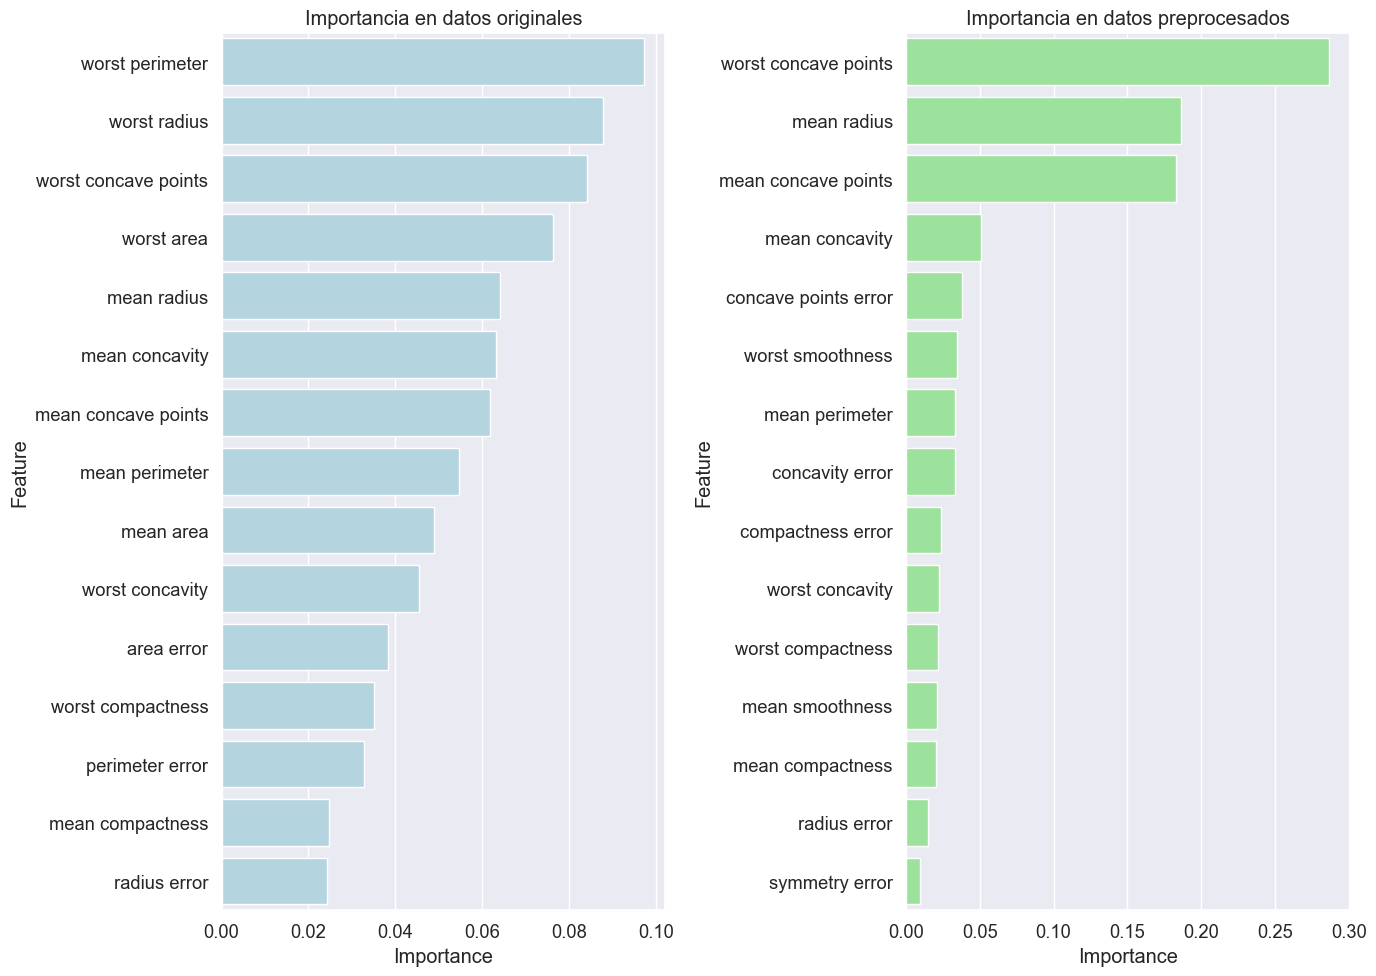

In [15]:
# Comparación: Extra Trees con datos originales vs. preprocesados
print("\n3.6. Comparación de Extra Trees con datos originales vs. preprocesados")

# Entrenamos Extra Trees con datos originales
et_orig = ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE)
et_orig, et_orig_metrics = evaluate_model(et_orig, X_train_orig, X_test_orig, 
                                         y_train_orig, y_test_orig, 
                                         "Extra Trees (original)")

# Creamos un DataFrame para comparar resultados
et_comparison_df = pd.DataFrame({
    'Modelo': ['Extra Trees (original)', 'Extra Trees (preprocesado)'],
    'Accuracy Train': [et_orig_metrics['accuracy_train'], et_metrics['accuracy_train']],
    'Accuracy Test': [et_orig_metrics['accuracy_test'], et_metrics['accuracy_test']],
    'Precision': [et_orig_metrics['precision'], et_metrics['precision']],
    'Recall': [et_orig_metrics['recall'], et_metrics['recall']],
    'F1-Score': [et_orig_metrics['f1'], et_metrics['f1']],
    'AUC-ROC': [et_orig_metrics.get('roc_auc', np.nan), et_metrics.get('roc_auc', np.nan)]
})

print("\nComparación de Extra Trees con datos originales vs. preprocesados:")
display(et_comparison_df)

# Visualizamos la comparación
plt.figure(figsize=(14, 6))
et_viz_df = et_comparison_df.melt(id_vars='Modelo', 
                                 var_name='Métrica', 
                                 value_name='Valor')
sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=et_viz_df)
plt.title('Comparación de Extra Trees: Datos originales vs. preprocesados')
plt.ylim(0.8, 1.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'{output_dir}/et_original_vs_preprocessed.png', dpi=100, bbox_inches='tight')
plt.show()

# Comparamos la importancia de características
plt.figure(figsize=(14, 10))
importance_et_orig = pd.DataFrame({
    'Feature': cancer.feature_names,
    'Importance': et_orig.feature_importances_
}).sort_values('Importance', ascending=False)

# Importancia para datos preprocesados
importance_et_prep = pd.DataFrame({
    'Feature': X_train_model.columns,
    'Importance': et_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualizamos las 15 características más importantes según ET original
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=importance_et_orig.head(15), color='lightblue')
plt.title('Importancia en datos originales')

# Visualizamos las características más importantes según ET con datos preprocesados
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=importance_et_prep.head(15), color='lightgreen')
plt.title('Importancia en datos preprocesados')

plt.tight_layout()
plt.savefig(f'{output_dir}/et_importance_comparison_orig_vs_prep.png', dpi=100, bbox_inches='tight')
plt.show()

Con datos originales, el modelo alcanza 95.61% de exactitud, mientras que tras el preprocesamiento, logra 100% en todas las métricas evaluadas.

La distribución de importancia de características presenta cambios importantes entre ambas versiones. Con datos originales, las variables de tamaño (worst perimeter, worst radius) ocupan las primeras posiciones, seguidas por medidas de concavidad. Sin embargo, tras el preprocesamiento, "worst concave points" y "mean concave points" son las más relevantes.

El proceso de transformación y selección de características ha permitido destacar las variables con mayor capacidad discriminativa para este problema (relacionadas con concavidad), cuya importancia quedaba parcialmente oculta en los datos originales por las medidas de tamaño.

## <font color="#000000"> 3.3. Evaluación comparativa de modelos</font><a id="section33"></a>

| Modelo | Accuracy (%) | Precision (%) | Recall (%) | F1-Score (%) | Datos |
|--------|--------------|--------------|------------|--------------|-------|
| Árbol de Decisión | 97.66 | 98.13 | 98.13 | 98.13 | Preprocesados |
| Regresión Logística | 100.00 | 100.00 | 100.00 | 100.00 | Preprocesados |
| SVM | 100.00 | 100.00 | 100.00 | 100.00 | Preprocesados |
| MLP | 100.00 | 100.00 | 100.00 | 100.00 | Preprocesados |
| Random Forest | 100.00 | 100.00 | 100.00 | 100.00 | Preprocesados |
| Bagging-DT | 98.83 | 99.07 | 99.07 | 99.07 | Preprocesados |
| Bagging-LR | 100.00 | 100.00 | 100.00 | 100.00 | Preprocesados |
| Bagging-SVM | 100.00 | 100.00 | 100.00 | 100.00 | Preprocesados |
| Extra Trees | 100.00 | 100.00 | 100.00 | 100.00 | Preprocesados |
| Random Forest | 93.56 | 94.44 | 95.33 | 94.88 | Original |
| Bagging-DT | 94.74 | 94.55 | 97.20 | 95.85 | Original |
| Bagging-LR | 94.15 | 92.92 | 98.13 | 95.45 | Original |
| Bagging-SVM | 91.23 | 91.07 | 95.33 | 93.15 | Original |
| Extra Trees | 97.08 | 96.36 | 99.07 | 97.70 | Original |

La tabla anterior muestra que seis de los nueve modelos con datos preprocesados alcanzan una exactitud perfecta, mientras que los modelos con datos originales muestran rendimiento inferior (91-97%). Los modelos basados en árboles individuales (Árbol de Decisión con 97.66% y Bagging-DT con 98.83%) son los únicos que no logran 100% de exactitud incluso con datos preprocesados. Es notable que el modelo Extra Trees con datos originales alcanza un rendimiento superior (97.08%) comparado con otros modelos sin preprocesamiento, lo que sugiere su mayor capacidad de adaptación a datos no transformados. El análisis de importancia de características identifica consistentemente "worst concave points" y "mean concave points" como las variables más determinantes para la clasificación entre tumores benignos y malignos.

## <font color="#000000"> 3.4. Selección de los tres mejores modelos</font><a id="section34"></a>

Para seleccionar los tres mejores modelos ensemble, podemos establecer algunos criterios como:
1. **Rendimiento cuantitativo**: Exactitud, precisión, sensibilidad y F1-Score
2. **Estabilidad**: Diferencia entre rendimiento en entrenamiento y prueba
3. **Interpretabilidad**: Capacidad para proporcionar importancia de características
4. **Versatilidad**: Rendimiento tanto con datos originales como preprocesados

| Modelo | Rendimiento (Datos prep.) | Estabilidad | Interpretabilidad | Versatilidad |
|--------|---------------------------|-------------|-------------------|--------------|
| Random Forest | 100% en todas las métricas | Alta | Alta | Buena (93.56% en original) |
| Bagging-DT | 98.83% exactitud | Media | Media | Buena (94.74% en original) |
| Bagging-LR | 100% en todas las métricas | Alta | Baja | Buena (94.15% en original) |
| Bagging-SVM | 100% en todas las métricas | Alta | Baja | Baja (91.23% en original) |
| Extra Trees | 100% en todas las métricas | Alta | Alta | Muy buena (97.08% en original) |

Basándonos en estos criterios, los tres mejores modelos podrían ser:

1. **Extra Trees**: Rendimiento perfecto con datos preprocesados y el mejor desempeño con datos originales (97.08%), combinado con alta interpretabilidad mediante su ranking de importancia de características. Su mayor capacidad para manejar datos sin preprocesar lo convierte en el modelo más versátil.

2. **Random Forest**: Rendimiento perfecto con datos preprocesados, alta interpretabilidad y buena versatilidad. Proporciona una perspectiva complementaria a Extra Trees en cuanto a importancia de variables.

3. **Bagging con Regresión Logística**: Combina las ventajas del ensemble con un clasificador lineal base, logrando rendimiento perfecto con datos preprocesados y buena versatilidad (94.15% con datos originales). Representa una aproximación distinta a los modelos basados en árboles.

In [16]:
# Guardar modelos y datos para optimización

# Crear directorio si no existe
os.makedirs('data/models', exist_ok=True)

# Guardar modelos seleccionados
models_to_optimize = {
    'random_forest': rf_model,
    'extra_trees': et_model,
    'bagging_lr': bagging_lr,
    'X_train': X_train_model,
    'X_test': X_test_model,
    'y_train': y_train_model,
    'y_test': y_test_model
}

# Guardar en archivo
with open('data/models/models_for_optimization.pkl', 'wb') as f:
    pickle.dump(models_to_optimize, f)

print("Modelos y datos guardados para fase de optimización.")

Modelos y datos guardados para fase de optimización.
